# Film Pigment

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
import rawpy
from pathlib import Path

In [12]:
drive = Path.home() / "Library/CloudStorage/GoogleDrive-louis.manestar@gmail.com/My Drive/"
folder_name = "02 Film Samples"
filename = "KENTMERE_100.NEF"

folder_path = drive / "Film Photos" / folder_name
image_path = folder_path / filename

### Load film image & preprocess

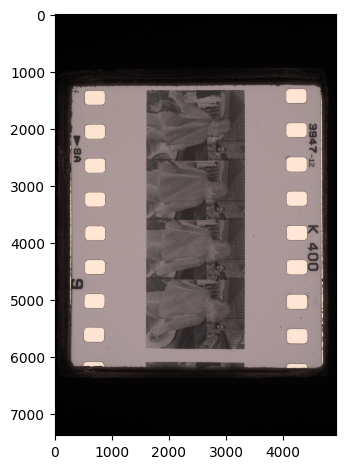

In [13]:
with rawpy.imread(image_path.as_posix()) as raw:
    image = ski.util.img_as_float32(raw.postprocess().copy())

ski.io.imshow(image)

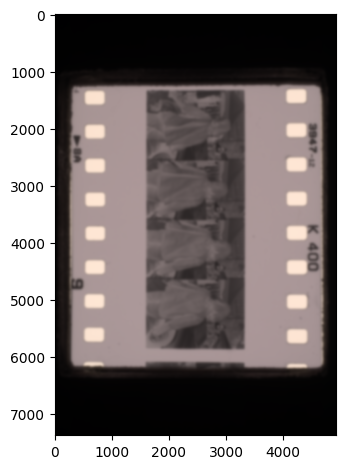

In [14]:
blurred = ski.filters.gaussian(image, sigma=(20, 20), channel_axis=-1)
ski.io.imshow(blurred)

### Obtain colour distribution

In [4]:
distribution, edges = np.histogramdd(blurred.reshape(-1, 3), bins=256, range=[(0,1), (0,1), (0, 1)],)

In [7]:
LIMIT_COLOURS = 80

sorted_count = np.sort(distribution, axis=None)[-LIMIT_COLOURS:]
indices = np.argsort(distribution, axis=None)[-LIMIT_COLOURS:]

sorted_colours = np.array(np.unravel_index(indices, shape=distribution.shape)).T
by_intensity = np.linalg.norm(sorted_colours, axis=1).argsort()

sorted_count_by_intensity = sorted_count[by_intensity]
sorted_colours_by_intensity = sorted_colours[by_intensity]

### Select `white` and `emulsion` colours

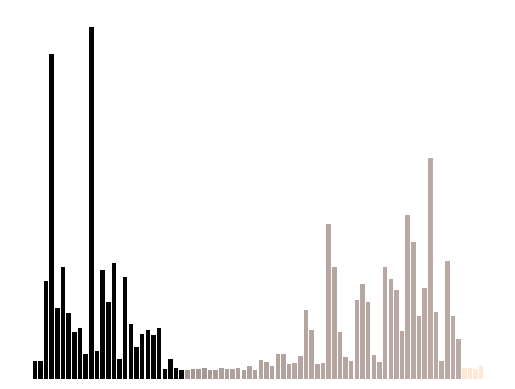

In [8]:
plt.bar(np.arange(LIMIT_COLOURS) + 1, sorted_count_by_intensity[-LIMIT_COLOURS:], color=sorted_colours_by_intensity[-LIMIT_COLOURS:] / 255)
plt.axis("off")
plt.show()

In [9]:
white = sorted_colours_by_intensity[-1]
emulsion = sorted_colours_by_intensity[-5]

print(f"White value: {tuple(white.tolist())}")
print(f"Emulsion value: {tuple(emulsion.tolist())}")

White value: (255, 233, 214)
Emulsion value: (187, 171, 165)


### Preprocess `emulsion` to get pigment

In [10]:
from nevernegative.layers.balancing.temperature import Temperature

pigment = (emulsion * 255 / white).astype(np.uint8)
temperature = Temperature.infer_temperature(white)

print(f"Pigment value: {tuple(pigment.tolist())}")
print(f"Estimated white temperature: {temperature:.0f}K.")


Pigment value: (187, 187, 196)
Estimated white temperature: 5268K.


(np.float64(-0.5), np.float64(4923.5), np.float64(7377.5), np.float64(-0.5))

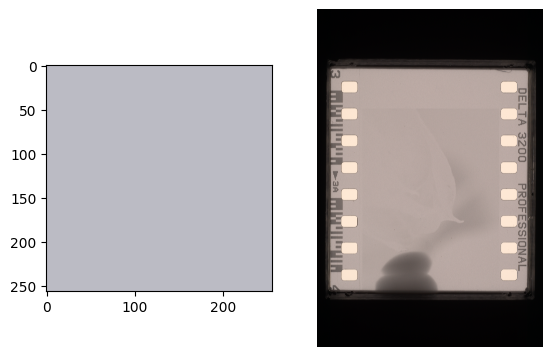

In [11]:
pigment_image = np.empty((256, 256, 3), dtype=np.uint8)
pigment_image[:, :] = pigment

figure, axes = plt.subplots(1, 2)
[pigment_axis, image_axis] = axes.ravel()

pigment_axis.imshow(pigment_image)
image_axis.imshow(image)

plt.axis("off")